In [1]:
# How do FGN feedforward neural networks perform when making predictions over random noise

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# # random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
!gpustat

countdown  Fri Aug  9 17:02:46 2019
[0] GeForce GTX 1080 | 41'C,   0 % |   659 /  8119 MB | felix(647M)
[1] GeForce GTX 1080 | 40'C,   0 % |   836 /  8118 MB |


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [8]:
# create random 28*28 images

# Random images dataset
x_rand = np.random.randint(low=0, high=255, size=(10000,28,28) )
# convert to [0,1] and apply same transforms as for MNIST training
x_rand = x_rand/255.0
x_rand = (x_rand-0.1307)/0.3081

# print(np.mean(x_rand))
# print(np.std(x_rand))

x_rand = torch.Tensor(x_rand)

rand_dataset = torch.utils.data.TensorDataset(x_rand)# create your dataset
rand_dataloader = torch.utils.data.DataLoader(rand_dataset, 
                                              batch_size=32, 
                                              ) # create your dataloader

Shape: torch.Size([10000, 28, 28])
torch.Size([28, 28])


<IPython.core.display.Javascript object>


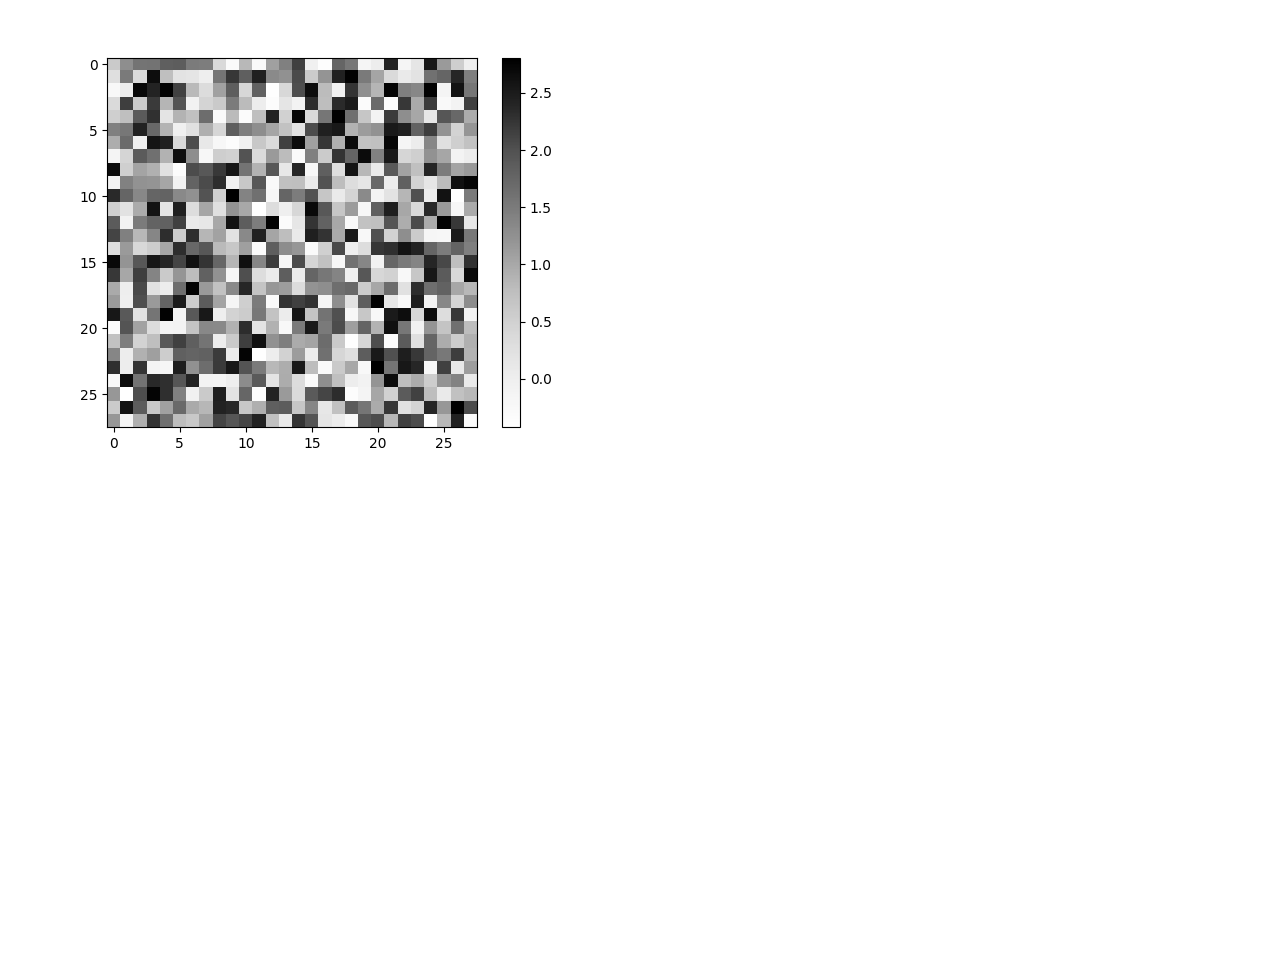

In [9]:
# show an example
print("Shape:", rand_dataloader.dataset.tensors[0].shape)
x = rand_dataloader.dataset.tensors[0][0]
print(x.shape)
# print("sample:", x)

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [10]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 192

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

In [11]:
#  test one model
model_path = "../Experiments/sample_models/sample_fgn_model_noisy_eval_overfitted_32_32_ord_1_full.pth"
dict_path =  "../Experiments/sample_models/sample_fgn_model_noisy_eval_overfitted_32_32_ord_1_state_dict.pth"
params_paths = "../Experiments/sample_models/sample_fgn_model_noisy_eval_overfitted_32_32_ord_1_parameters.txt"

print(model_path)

../Experiments/sample_models/sample_fgn_model_noisy_eval_overfitted_32_32_ord_1_full.pth


In [12]:
# exp params
with open(params_paths) as f: 
    print(f.read())

hidden_l_nums [32, 32]
drop_p 0.2
noisy_centers False
batch_size 192



In [13]:
# # full load
model = torch.load(model_path)
model.to(device)

# dict load
# model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_l_nums=[32,32], 
#                                      drop_p=0.0  , noisy_centers=False).to(device)
# model.load_state_dict(state_dict=torch.load(dict_path))

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [14]:
# loss functions for the classic net
lmbda_l2 = 0.0
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

0.0


In [15]:
# test the model over mnist
model.set_random_eval(False)
test_res = fgnh.test(model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3304, Accuracy: 54325/60000 (91%)


In [16]:
# change to random eval
model.set_random_eval(True)
test_res = fgnh.test(model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(model, mnist_test_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3304, Accuracy: 54312/60000 (91%)
Test set - Average loss: 0.3347, Accuracy: 9074/10000 (91%)


In [25]:
# set model to eval mode
model.eval()
#check both eval mode and random eval
print(model.training)
for l in model.hidden_layers:
    if isinstance(l, fgnl.FGN_layer):
        print(l.random_eval)
        break

False
True


In [19]:
# apply model to random data
    
preds = model(x_rand.to(device))
preds = preds.cpu().detach().numpy()
# apply softmax for probs
preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])

In [20]:
# print first 5 pred
print(np.round(preds_softmax[:5],decimals=2))
print("shape:", preds.shape)

[[0.   0.03 0.25 0.08 0.03 0.2  0.12 0.26 0.   0.02]
 [0.   0.03 0.25 0.08 0.03 0.2  0.12 0.26 0.   0.02]
 [0.   0.03 0.25 0.08 0.03 0.2  0.12 0.26 0.   0.02]
 [0.   0.03 0.25 0.08 0.03 0.2  0.12 0.26 0.   0.02]
 [0.   0.03 0.25 0.08 0.03 0.2  0.12 0.26 0.   0.02]]
shape: (10000, 10)


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


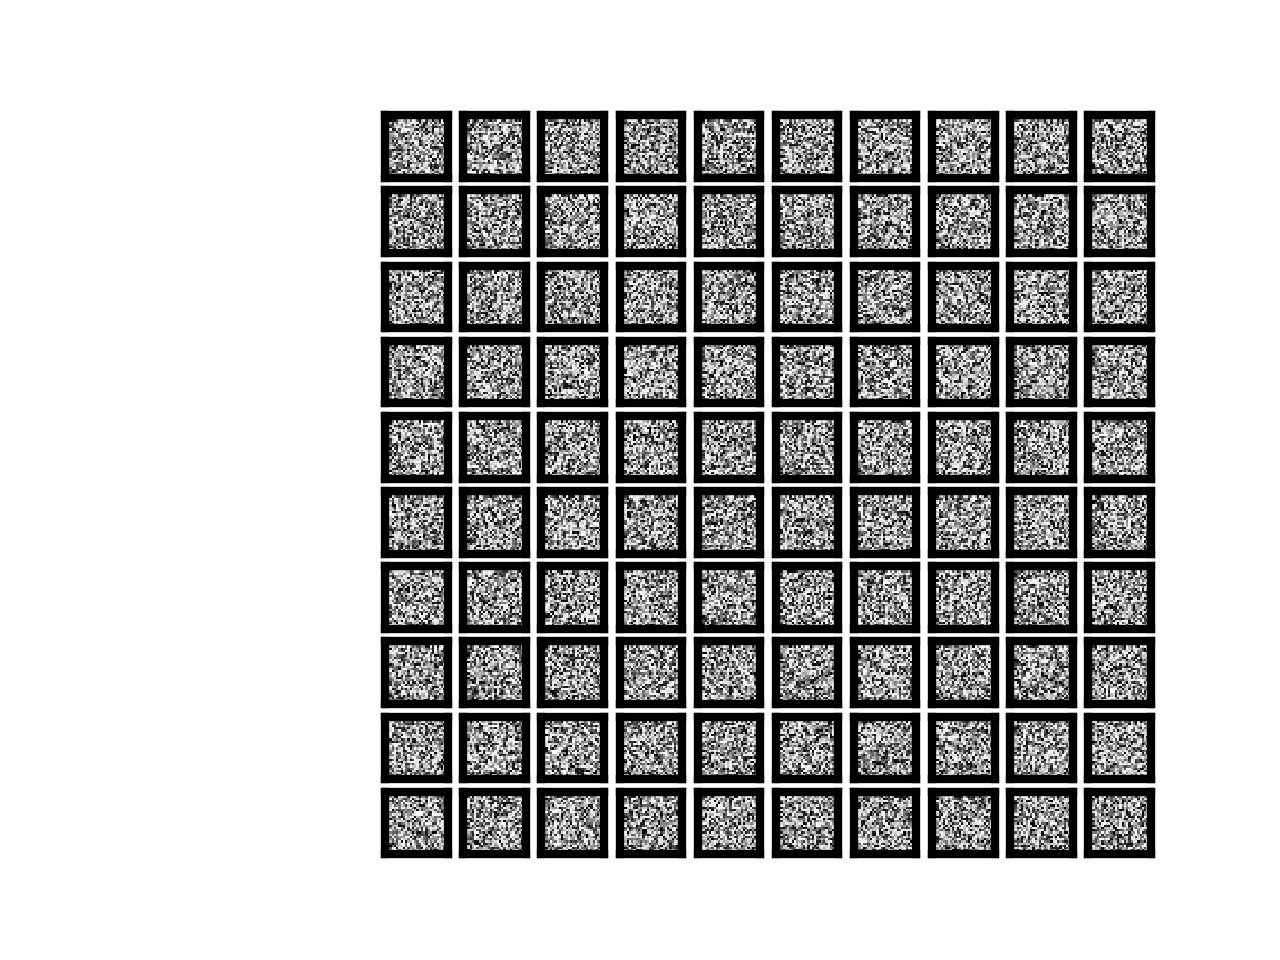

In [21]:
# plot
fig, axes = plt.subplots(nrows=10, ncols=10)
for r in range(10):
    for c in range(10):
        
        x = rand_dataloader.dataset[10*r+c][0].numpy().reshape((28,28))
        
        # is the max bigger than rest combined?
        if np.max(preds_softmax[10*r+c])>=0.5:
            axes[r,c].spines['bottom'].set_color('tab:red')
            axes[r,c].spines['top'].set_color('tab:red')
            axes[r,c].spines['left'].set_color('tab:red')
            axes[r,c].spines['right'].set_color('tab:red')
        
        # is the max close to the min?
        if np.max(preds_softmax[10*r+c])<=0.2:            
            axes[r,c].spines['bottom'].set_color('tab:blue')
            axes[r,c].spines['top'].set_color('tab:blue')
            axes[r,c].spines['left'].set_color('tab:blue')
            axes[r,c].spines['right'].set_color('tab:blue')
            
        axes[r,c].spines['bottom'].set_linewidth(3)
        axes[r,c].spines['top'].set_linewidth(3)
        axes[r,c].spines['left'].set_linewidth(3)
        axes[r,c].spines['right'].set_linewidth(3)
        axes[r,c].tick_params(axis='both', labelbottom='off', labelleft='off', bottom='off', left='off')

        axes[r,c].imshow(x, cmap=plt.cm.get_cmap('Greys'))
#         axes[r,c].axis('off')
plt.subplots_adjust(left=0.3, hspace=0.2)
plt.show()

In [22]:
# quick description of the maxes
preds_maxes = np.max(preds_softmax, axis=1)
print(stats.describe(preds_maxes))
# % of maxes above 0.9
print(len([x for x in preds_maxes if x>=0.9]))

DescribeResult(nobs=10000, minmax=(0.26203250795302362566, 0.26203250795302362566), mean=0.26203250795302362569, variance=7.347574450084305356e-40, skewness=-1.0, kurtosis=-2.0)
0


<IPython.core.display.Javascript object>


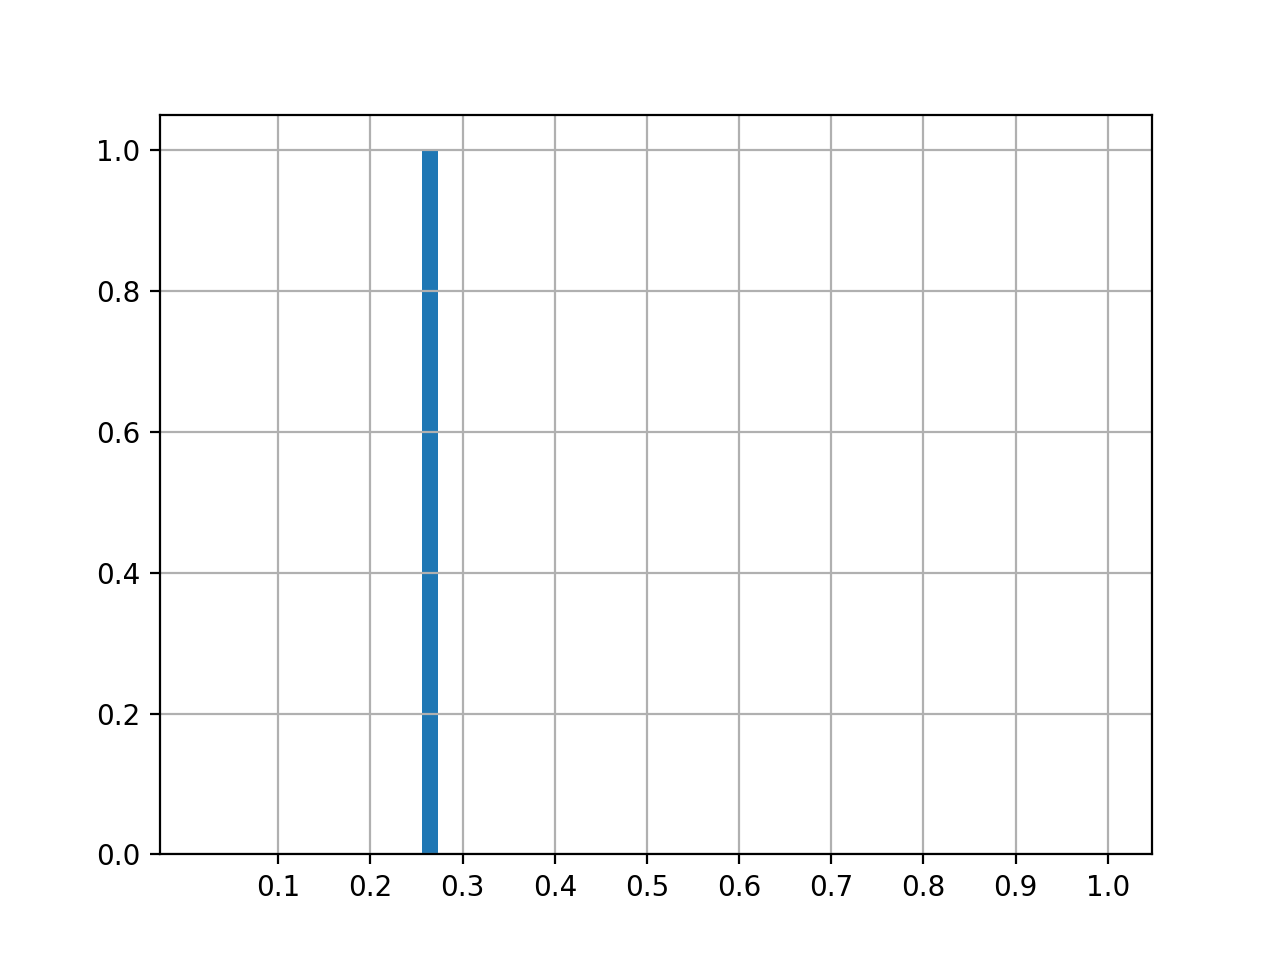

In [23]:
# histogram
weights = np.ones_like(preds_maxes)/len(preds_maxes)
plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
plt.xticks((np.arange(10)+1)/10.0)
plt.grid(True)
plt.show()

In [ ]:
# ### Part 2 - Test all the pre-trained models

# import os

# all_model_paths = sorted([file for file in os.listdir(model_dir) if file.endswith("_full.pth")])
# networks_sizes = [[], [8], [128], [1024], [8,8], [128,128], [1024,1024], [8,8,8], [128,128,128], [1024,1024,1024]]


In [ ]:
# # results will be of the form:
# # {model_name: res} with res being a list with the predictions for each class
# results_dict = {}

# for model_path in all_model_paths:
    
#     # full model load
#     print("loading model", model_path)
#     loaded_model = torch.load(model_dir+'/'+model_path)
#     loaded_model.to(device)
    
#     # apply model to data
#     # get predictions 
#     print("making predictions")
#     predictions = np.array([])
#     for data in rand_dataloader:
#         data = data[0].to(device)
#         pred = loaded_model(data).cpu().detach().numpy()
#         try:
#             predictions = np.concatenate((predictions,pred))
#         except:
#             predictions=pred        

#     # for some reason the networks make log_softmax predictions
#     predictions = np.exp(predictions)
    
#     # we really only care about the max
#     maxes = [np.max(p) for p in predictions]
    
#     # add to dict
#     results_dict[model_path] = maxes

In [ ]:
# from scipy.stats import describe
# maxes_test = results_dict["model_[8, 8]_exp_0_full.pth"]
# print("Min of maxes:", np.min(maxes_test))
# print(describe(maxes_test))

In [ ]:
# weights = np.ones_like(maxes_test)/len(maxes_test)
# plt.hist(maxes_test, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
# plt.xticks((np.arange(10)+1)/10.0)
# plt.grid(True)
# plt.show()

In [ ]:
# # plot the histogram for each model

# for size in networks_sizes:
#     print("Network size", size)
#     subplot_num = 0
#     for k in results_dict.keys():
#         if str(size) in k:
#             subplot_num += 1
#             axe = plt.subplot(12,1, subplot_num)
#             axe.hist(results_dict[k], bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)
#             plt.xticks((np.arange(10)+1)/10.0)
#         #     plt.yticks((np.arange(0,11,2))/10.0)
#             plt.grid(True)
#     plt.show()